<a href="https://colab.research.google.com/github/jaejunchoe/HAIDS-Lab/blob/main/Upload_D_attn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비준비

In [ ]:
## 1번 실행 -> 런타임 다시 시작 -> 2번 실행 -> 3번 실행

## 1번

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,576 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123633 files and dire

In [ ]:
## 2번

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

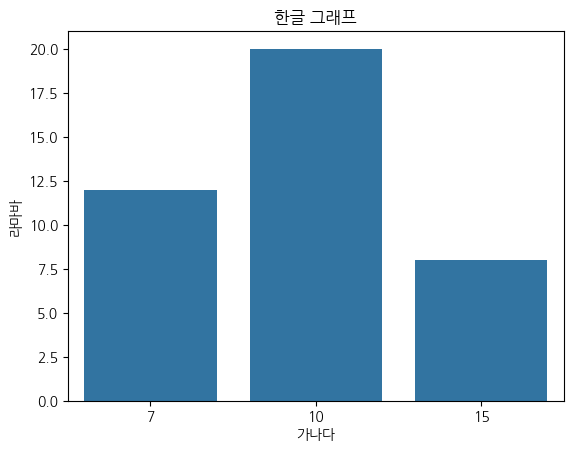

In [ ]:
## 3번

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 폰트 경로 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

# 그래프 그리기 예시
data = {'가나다': [10, 15, 7], '라마바': [20, 8, 12]}
df = pd.DataFrame(data)
sns.barplot(data=df, x='가나다', y='라마바')
plt.title('한글 그래프')
plt.show()


# 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data_loader

In [ ]:
import pickle
import numpy as np
import pandas as pd
import torch
from nltk import word_tokenize
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate


class ReviewDataset(Dataset):
    def __init__(self, csv_path, emb_path, max_len=10000, embed_size=64):
        """
        데이터셋 클래스
        :param csv_path: 전처리된 CSV 파일 경로
        :param emb_path: 단어 임베딩 파일 경로
        :param max_len: 리뷰 최대 길이
        :param embed_size: 임베딩 차원
        """
        self.dataset = pd.read_csv(csv_path, header=None, names=['userID', 'itemID', 'review', 'rating'])

        # 단어 임베딩 로드
        with open(emb_path, 'rb') as f:
            self.word_emb = pickle.load(f)

        # 임베딩 벡터 설정
        self.pad = np.zeros(embed_size)
        self.unknown = np.random.uniform(0, 1, embed_size)
        self.delimiter = np.random.uniform(0, 1, embed_size)

        # 하이퍼파라미터
        self.max_len = max_len
        self.embed_size = embed_size

    def __getitem__(self, index):
        """
        하나의 데이터 샘플을 가져옵니다.
        """
        row = self.dataset.loc[index]
        user_id = row['userID']
        item_id = row['itemID']

        # 리뷰 데이터
        user_review = self.preprocess_review(user_id, "User")
        item_review = self.preprocess_review(item_id, "Item")

        # 평점
        rating = torch.tensor(row['rating'], dtype=torch.float)

        return torch.tensor(user_review, dtype=torch.float), \
               torch.tensor(item_review, dtype=torch.float), \
               rating

    def __len__(self):
        return len(self.dataset)

    def preprocess_review(self, entity_id, entity_type):
        """
        리뷰 파일을 로드하고 임베딩을 적용합니다.
        """
        file_path = f"data/{entity_type}/{entity_id}.tsv"

        try:
            reviews = pd.read_csv(file_path, sep='\t', header=None)
        except Exception:
            return [self.pad] * self.max_len

        total_review = []
        for review_str in reviews[0][:100]:  # 최대 100개의 리뷰 단어
            tokens = word_tokenize(review_str)
            for word in tokens:
                if word in self.word_emb:
                    total_review.append(self.word_emb[word])
                else:
                    total_review.append(self.unknown)
            total_review.append(self.delimiter)

        # 리뷰 길이 조정 (패딩 또는 자르기)
        if len(total_review) < self.max_len:
            pad_len = self.max_len - len(total_review)
            total_review += [self.pad] * pad_len
        else:
            total_review = total_review[:self.max_len]

        return np.array(total_review)


def my_collate(batch):
    """
    None 데이터를 필터링하는 Collate 함수.
    """
    batch = list(filter(lambda x: x is not None, batch))
    return default_collate(batch)


def get_loader(csv_path, emb_path, batch_size=32, shuffle=True, num_workers=2):
    """
    데이터 로더 생성 함수.
    :param csv_path: 전처리된 CSV 파일 경로
    :param emb_path: 단어 임베딩 파일 경로
    """
    dataset = ReviewDataset(csv_path, emb_path)
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=my_collate)
    return data_loader


# 파일 경로 설정
train_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2_train.csv'
valid_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2__valid.csv'
test_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/cleaned_Transnet_T2_test.csv'
emb_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/combined_word_emb.pkl'

# 데이터 로더 생성
train_loader = get_loader(train_path, emb_path, batch_size=32, shuffle=True)
valid_loader = get_loader(valid_path, emb_path, batch_size=32, shuffle=False)
test_loader = get_loader(test_path, emb_path, batch_size=32, shuffle=False)

# 데이터 확인
for i, (user_review, item_review, rating) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"User Review Tensor: {user_review.shape}")
    print(f"Item Review Tensor: {item_review.shape}")
    print(f"Rating Tensor: {rating.shape}")
    break


<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Batch 1:
User Review Tensor: torch.Size([32, 10000, 64])
Item Review Tensor: torch.Size([32, 10000, 64])
Rating Tensor: torch.Size([32])


만약 너무 느리다면? 아래의 코드로 수정



def __getitem__(self, index):
    """
    하나의 데이터 샘플을 가져옵니다.
    """
    row = self.dataset.loc[index]
    user_id = row['userID']
    item_id = row['itemID']
    
    # 리뷰 데이터
    user_review = np.array(self.preprocess_review(user_id, "User"))  # numpy 변환 추가
    item_review = np.array(self.preprocess_review(item_id, "Item"))  # numpy 변환 추가
    
    # 평점
    rating = torch.tensor(row['rating'], dtype=torch.float)
    
    return torch.tensor(user_review, dtype=torch.float), \
           torch.tensor(item_review, dtype=torch.float), \
           rating


# Model architecture

In [ ]:
import torch
import torch.nn as nn
#from torch.autograd import Variable

In [ ]:
import torch
import torch.nn as nn

class LocalAttention(nn.Module):
    def __init__(self, input_size, embed_size, win_size, out_channels):
        super(LocalAttention, self).__init__()

        self.win_size = win_size
        self.attention_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(win_size, embed_size)),
            nn.Sigmoid())

        self.cnn = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(1, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size, 1)))

    def forward(self, x):
        # Padding dynamically to ensure compatibility
        #padding = torch.zeros(x.size(0), (self.win_size - 1) // 2, x.size(-1))
        padding = torch.zeros(x.size(0), (self.win_size - 1) // 2, x.size(-1), device=x.device)
        x_pad = torch.cat((padding, x, padding), 1).unsqueeze(1)

        scores = self.attention_layer(x_pad).squeeze(1)
        out = torch.mul(x, scores).unsqueeze(1)
        out = self.cnn(out)
        return out


class GlobalAttention(nn.Module):
    def __init__(self, input_size, embed_size, out_channels):
        super(GlobalAttention, self).__init__()

        self.attention_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(input_size, embed_size)),
            nn.Sigmoid())

        self.cnn_1 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(2, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 2 + 1, 1)))
        self.cnn_2 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(3, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 3 + 1, 1)))
        self.cnn_3 = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=(4, embed_size)),
            nn.Tanh(),
            nn.MaxPool2d((input_size - 4 + 1, 1)))

    def forward(self, x):
        x = x.unsqueeze(1)
        score = self.attention_layer(x)
        out = torch.mul(x, score)
        return self.cnn_1(out), self.cnn_2(out), self.cnn_3(out)


class CNNDLGA(nn.Module):
    def __init__(self, input_size, embed_size=100, win_size=5, channels_local=200, channels_global=100,
                 hidden_size=500, output_size=50):
        super(CNNDLGA, self).__init__()

        self.localAttentionLayer_user = LocalAttention(input_size, embed_size, win_size, channels_local)
        self.globalAttentionLayer_user = GlobalAttention(input_size, embed_size, channels_global)
        self.localAttentionLayer_item = LocalAttention(input_size, embed_size, win_size, channels_local)
        self.globalAttentionLayer_item = GlobalAttention(input_size, embed_size, channels_global)

        # Fully Connected Layer
        self.fcLayer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # 입력 차원을 명시하지 않음
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x_user, x_item):
        # User side
        local_user = self.localAttentionLayer_user(x_user)
        global1_user, global2_user, global3_user = self.globalAttentionLayer_user(x_user)
        out_user = torch.cat((local_user, global1_user, global2_user, global3_user), 1).view(x_user.size(0), -1)
        out_user = self.fcLayer(out_user)

        # Item side
        local_item = self.localAttentionLayer_item(x_item)
        global1_item, global2_item, global3_item = self.globalAttentionLayer_item(x_item)
        out_item = torch.cat((local_item, global1_item, global2_item, global3_item), 1).view(x_item.size(0), -1)
        out_item = self.fcLayer(out_item)

        # Combine user and item representations
        out = torch.sum(torch.mul(out_user, out_item), 1)
        return out


# Training and Result

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pickle
import numpy as np
from sklearn import metrics

# ================= Hyperparameters =================
input_size = 10000        # 리뷰 길이
embed_size = 64           # 임베딩 차원
num_epochs = 10           # 학습 에폭 수
batch_size = 32           # 배치 사이즈
learning_rate = 1e-4      # 학습률
hidden_size = 500         # FC 레이어 히든 사이즈
output_size = 1           # 출력 사이즈 (평점 예측)
win_size = 5              # 윈도우 크기
channels_local = 200      # LocalAttention 채널 수
channels_global = 100     # GlobalAttention 채널 수

# ================= Utility Functions =================
#def evaluation(target, cf_out):
#    """AUC 계산"""
#    fpr, tpr, _ = metrics.roc_curve(target, cf_out)
#    auc = metrics.auc(fpr, tpr)
#    return auc

def to_var(x):
    """CUDA 변환 함수"""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# ================= Loading Data =================
print("Loading data...")

# DataLoader 생성
train_loader = get_loader(train_path, emb_path, batch_size=batch_size, shuffle=True)
valid_loader = get_loader(valid_path, emb_path, batch_size=batch_size, shuffle=False)
test_loader = get_loader(test_path, emb_path, batch_size=batch_size, shuffle=False)

print(f"train/valid/test: {len(train_loader)}/{len(valid_loader)}/{len(test_loader)}")
print("=" * 80)

# ================= Model Initialization =================
model = CNNDLGA(input_size=input_size, embed_size=embed_size, win_size=win_size,
                channels_local=channels_local, channels_global=channels_global,
                hidden_size=hidden_size, output_size=output_size)

if torch.cuda.is_available():
    model.cuda()

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("=" * 80)
print("Training Start..")

# ================= Training Loop =================
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    batch_loss = 0.0

    for i, (user_review, item_review, labels) in enumerate(train_loader):
        # 데이터 CUDA 변환
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        # Forward
        outputs = model(user_review, item_review)
        loss = criterion(outputs, labels)

        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], "
                  f"Loss: {batch_loss / 10:.4f}")
            batch_loss = 0.0

    # 모델 저장
    #torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pkl")
    save_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/model save/'  # Google Drive 저장 경로
    torch.save(model.state_dict(), f"{save_path}model_epoch_{epoch+1}.pkl")


print("=" * 80)
print("Training End..")

# ================= Validation Loop =================



print("Validation Start...")
model.eval()
all_outputs = []
all_labels = []

with torch.no_grad():
    for user_review, item_review, labels in valid_loader:
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        outputs = model(user_review, item_review)
        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# AUC 계산
#auc = evaluation(all_labels, all_outputs)
#print(f"Validation AUC: {auc:.4f}")
#print("=" * 80)







# ================= Testing Loop =================
print("Testing Start...")
all_outputs = []

with torch.no_grad():
    for user_review, item_review, labels in test_loader:
        user_review = to_var(user_review)
        item_review = to_var(item_review)

        outputs = model(user_review, item_review)
        all_outputs.extend(outputs.cpu().numpy())

# 결과 저장
with open("/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/result_test.pickle", "wb") as f:
    pickle.dump(all_outputs, f)

print("Testing End. Results saved to 'result_test.pickle'.")
print("=" * 80)

Loading data...
train/valid/test: 400/50/50
Training Start..


<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [1/10], Step [10/400], Loss: 16.9719
Epoch [1/10], Step [20/400], Loss: 16.4707
Epoch [1/10], Step [30/400], Loss: 15.9221
Epoch [1/10], Step [40/400], Loss: 15.3367
Epoch [1/10], Step [50/400], Loss: 14.5974
Epoch [1/10], Step [60/400], Loss: 13.5155
Epoch [1/10], Step [70/400], Loss: 10.3707
Epoch [1/10], Step [80/400], Loss: 7.6027
Epoch [1/10], Step [90/400], Loss: 5.1182
Epoch [1/10], Step [100/400], Loss: 2.9699
Epoch [1/10], Step [110/400], Loss: 2.5935
Epoch [1/10], Step [120/400], Loss: 3.0695
Epoch [1/10], Step [130/400], Loss: 2.5003
Epoch [1/10], Step [140/400], Loss: 2.5309
Epoch [1/10], Step [150/400], Loss: 2.7779
Epoch [1/10], Step [160/400], Loss: 2.7100
Epoch [1/10], Step [170/400], Loss: 2.5811
Epoch [1/10], Step [180/400], Loss: 2.8049
Epoch [1/10], Step [190/400], Loss: 2.4692
Epoch [1/10], Step [200/400], Loss: 2.5675
Epoch [1/10], Step [210/400], Loss: 2.3837
Epoch [1/10], Step [220/400], Loss: 2.5475
Epoch [1/10], Step [230/400], Loss: 2.5970
Epoch [1/10],

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [2/10], Step [10/400], Loss: 2.5004
Epoch [2/10], Step [20/400], Loss: 2.6830
Epoch [2/10], Step [30/400], Loss: 2.5208
Epoch [2/10], Step [40/400], Loss: 2.5213
Epoch [2/10], Step [50/400], Loss: 2.6493
Epoch [2/10], Step [60/400], Loss: 2.2098
Epoch [2/10], Step [70/400], Loss: 2.4943
Epoch [2/10], Step [80/400], Loss: 2.5051
Epoch [2/10], Step [90/400], Loss: 2.7184
Epoch [2/10], Step [100/400], Loss: 2.4395
Epoch [2/10], Step [110/400], Loss: 2.7811
Epoch [2/10], Step [120/400], Loss: 2.5636
Epoch [2/10], Step [130/400], Loss: 2.6296
Epoch [2/10], Step [140/400], Loss: 2.6774
Epoch [2/10], Step [150/400], Loss: 2.5141
Epoch [2/10], Step [160/400], Loss: 2.6182
Epoch [2/10], Step [170/400], Loss: 2.6590
Epoch [2/10], Step [180/400], Loss: 2.6332
Epoch [2/10], Step [190/400], Loss: 2.6039
Epoch [2/10], Step [200/400], Loss: 2.6499
Epoch [2/10], Step [210/400], Loss: 2.5344
Epoch [2/10], Step [220/400], Loss: 2.7686
Epoch [2/10], Step [230/400], Loss: 2.4972
Epoch [2/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [3/10], Step [10/400], Loss: 2.4954
Epoch [3/10], Step [20/400], Loss: 2.5110
Epoch [3/10], Step [30/400], Loss: 2.3518
Epoch [3/10], Step [40/400], Loss: 2.6719
Epoch [3/10], Step [50/400], Loss: 2.4759
Epoch [3/10], Step [60/400], Loss: 2.5939
Epoch [3/10], Step [70/400], Loss: 2.4971
Epoch [3/10], Step [80/400], Loss: 2.3794
Epoch [3/10], Step [90/400], Loss: 2.5468
Epoch [3/10], Step [100/400], Loss: 2.4520
Epoch [3/10], Step [110/400], Loss: 2.7136
Epoch [3/10], Step [120/400], Loss: 2.7511
Epoch [3/10], Step [130/400], Loss: 2.6022
Epoch [3/10], Step [140/400], Loss: 2.6916
Epoch [3/10], Step [150/400], Loss: 2.5992
Epoch [3/10], Step [160/400], Loss: 2.5545
Epoch [3/10], Step [170/400], Loss: 2.5099
Epoch [3/10], Step [180/400], Loss: 2.5854
Epoch [3/10], Step [190/400], Loss: 2.7476
Epoch [3/10], Step [200/400], Loss: 2.6408
Epoch [3/10], Step [210/400], Loss: 2.5570
Epoch [3/10], Step [220/400], Loss: 2.5072
Epoch [3/10], Step [230/400], Loss: 2.7418
Epoch [3/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [4/10], Step [10/400], Loss: 2.8671
Epoch [4/10], Step [20/400], Loss: 2.3851
Epoch [4/10], Step [30/400], Loss: 2.2614
Epoch [4/10], Step [40/400], Loss: 2.3677
Epoch [4/10], Step [50/400], Loss: 2.5357
Epoch [4/10], Step [60/400], Loss: 2.6519
Epoch [4/10], Step [70/400], Loss: 2.5575
Epoch [4/10], Step [80/400], Loss: 2.6180
Epoch [4/10], Step [90/400], Loss: 2.7396
Epoch [4/10], Step [100/400], Loss: 2.5483
Epoch [4/10], Step [110/400], Loss: 2.3803
Epoch [4/10], Step [120/400], Loss: 2.6225
Epoch [4/10], Step [130/400], Loss: 2.3887
Epoch [4/10], Step [140/400], Loss: 2.3568
Epoch [4/10], Step [150/400], Loss: 2.4316
Epoch [4/10], Step [160/400], Loss: 2.7848
Epoch [4/10], Step [170/400], Loss: 2.6482
Epoch [4/10], Step [180/400], Loss: 2.7590
Epoch [4/10], Step [190/400], Loss: 2.4920
Epoch [4/10], Step [200/400], Loss: 2.6109
Epoch [4/10], Step [210/400], Loss: 2.6399
Epoch [4/10], Step [220/400], Loss: 2.5439
Epoch [4/10], Step [230/400], Loss: 2.4499
Epoch [4/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [5/10], Step [10/400], Loss: 2.7920
Epoch [5/10], Step [20/400], Loss: 2.5345
Epoch [5/10], Step [30/400], Loss: 2.5291
Epoch [5/10], Step [40/400], Loss: 2.5610
Epoch [5/10], Step [50/400], Loss: 2.3967
Epoch [5/10], Step [60/400], Loss: 2.6377
Epoch [5/10], Step [70/400], Loss: 2.6743
Epoch [5/10], Step [80/400], Loss: 2.6320
Epoch [5/10], Step [90/400], Loss: 2.5558
Epoch [5/10], Step [100/400], Loss: 2.4557
Epoch [5/10], Step [110/400], Loss: 2.5996
Epoch [5/10], Step [120/400], Loss: 2.4851
Epoch [5/10], Step [130/400], Loss: 2.8017
Epoch [5/10], Step [140/400], Loss: 2.3647
Epoch [5/10], Step [150/400], Loss: 2.5515
Epoch [5/10], Step [160/400], Loss: 2.5877
Epoch [5/10], Step [170/400], Loss: 2.5121
Epoch [5/10], Step [180/400], Loss: 2.4652
Epoch [5/10], Step [190/400], Loss: 2.3947
Epoch [5/10], Step [200/400], Loss: 2.3650
Epoch [5/10], Step [210/400], Loss: 2.3736
Epoch [5/10], Step [220/400], Loss: 2.5626
Epoch [5/10], Step [230/400], Loss: 2.7639
Epoch [5/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [6/10], Step [10/400], Loss: 2.7887
Epoch [6/10], Step [20/400], Loss: 2.7064
Epoch [6/10], Step [30/400], Loss: 2.3826
Epoch [6/10], Step [40/400], Loss: 2.7219
Epoch [6/10], Step [50/400], Loss: 2.6864
Epoch [6/10], Step [60/400], Loss: 2.1604
Epoch [6/10], Step [70/400], Loss: 2.6555
Epoch [6/10], Step [80/400], Loss: 2.6410
Epoch [6/10], Step [90/400], Loss: 2.8095
Epoch [6/10], Step [100/400], Loss: 2.5176
Epoch [6/10], Step [110/400], Loss: 2.5242
Epoch [6/10], Step [120/400], Loss: 2.4716
Epoch [6/10], Step [130/400], Loss: 2.3612
Epoch [6/10], Step [140/400], Loss: 2.5074
Epoch [6/10], Step [150/400], Loss: 2.6473
Epoch [6/10], Step [160/400], Loss: 2.7594
Epoch [6/10], Step [170/400], Loss: 2.6225
Epoch [6/10], Step [180/400], Loss: 2.4537
Epoch [6/10], Step [190/400], Loss: 2.5978
Epoch [6/10], Step [200/400], Loss: 2.1164
Epoch [6/10], Step [210/400], Loss: 2.5291
Epoch [6/10], Step [220/400], Loss: 2.7025
Epoch [6/10], Step [230/400], Loss: 2.5307
Epoch [6/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [7/10], Step [10/400], Loss: 2.4855
Epoch [7/10], Step [20/400], Loss: 2.5413
Epoch [7/10], Step [30/400], Loss: 2.4174
Epoch [7/10], Step [40/400], Loss: 2.2779
Epoch [7/10], Step [50/400], Loss: 2.5488
Epoch [7/10], Step [60/400], Loss: 2.6491
Epoch [7/10], Step [70/400], Loss: 2.5118
Epoch [7/10], Step [80/400], Loss: 2.4463
Epoch [7/10], Step [90/400], Loss: 2.5541
Epoch [7/10], Step [100/400], Loss: 2.5161
Epoch [7/10], Step [110/400], Loss: 2.3879
Epoch [7/10], Step [120/400], Loss: 2.5269
Epoch [7/10], Step [130/400], Loss: 2.5490
Epoch [7/10], Step [140/400], Loss: 2.6187
Epoch [7/10], Step [150/400], Loss: 2.8513
Epoch [7/10], Step [160/400], Loss: 2.5192
Epoch [7/10], Step [170/400], Loss: 2.5944
Epoch [7/10], Step [180/400], Loss: 2.3400
Epoch [7/10], Step [190/400], Loss: 2.3331
Epoch [7/10], Step [200/400], Loss: 2.7144
Epoch [7/10], Step [210/400], Loss: 2.9153
Epoch [7/10], Step [220/400], Loss: 2.5199
Epoch [7/10], Step [230/400], Loss: 2.5488
Epoch [7/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [8/10], Step [10/400], Loss: 2.5210
Epoch [8/10], Step [20/400], Loss: 2.4522
Epoch [8/10], Step [30/400], Loss: 2.6134
Epoch [8/10], Step [40/400], Loss: 2.4135
Epoch [8/10], Step [50/400], Loss: 2.3684
Epoch [8/10], Step [60/400], Loss: 2.6005
Epoch [8/10], Step [70/400], Loss: 2.2644
Epoch [8/10], Step [80/400], Loss: 2.5478
Epoch [8/10], Step [90/400], Loss: 2.5772
Epoch [8/10], Step [100/400], Loss: 2.5443
Epoch [8/10], Step [110/400], Loss: 2.4912
Epoch [8/10], Step [120/400], Loss: 2.7153
Epoch [8/10], Step [130/400], Loss: 2.5272
Epoch [8/10], Step [140/400], Loss: 2.8694
Epoch [8/10], Step [150/400], Loss: 2.7870
Epoch [8/10], Step [160/400], Loss: 2.4028
Epoch [8/10], Step [170/400], Loss: 2.6353
Epoch [8/10], Step [180/400], Loss: 2.6029
Epoch [8/10], Step [190/400], Loss: 2.6796
Epoch [8/10], Step [200/400], Loss: 2.3671
Epoch [8/10], Step [210/400], Loss: 2.6655
Epoch [8/10], Step [220/400], Loss: 2.5226
Epoch [8/10], Step [230/400], Loss: 2.2463
Epoch [8/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [9/10], Step [10/400], Loss: 2.4467
Epoch [9/10], Step [20/400], Loss: 2.6405
Epoch [9/10], Step [30/400], Loss: 2.5250
Epoch [9/10], Step [40/400], Loss: 2.5490
Epoch [9/10], Step [50/400], Loss: 2.4500
Epoch [9/10], Step [60/400], Loss: 2.5031
Epoch [9/10], Step [70/400], Loss: 2.5616
Epoch [9/10], Step [80/400], Loss: 2.4595
Epoch [9/10], Step [90/400], Loss: 2.3687
Epoch [9/10], Step [100/400], Loss: 2.7539
Epoch [9/10], Step [110/400], Loss: 2.6041
Epoch [9/10], Step [120/400], Loss: 2.3762
Epoch [9/10], Step [130/400], Loss: 2.1874
Epoch [9/10], Step [140/400], Loss: 2.6136
Epoch [9/10], Step [150/400], Loss: 2.5484
Epoch [9/10], Step [160/400], Loss: 2.4921
Epoch [9/10], Step [170/400], Loss: 2.7805
Epoch [9/10], Step [180/400], Loss: 2.6155
Epoch [9/10], Step [190/400], Loss: 2.3444
Epoch [9/10], Step [200/400], Loss: 2.6070
Epoch [9/10], Step [210/400], Loss: 2.4321
Epoch [9/10], Step [220/400], Loss: 2.4007
Epoch [9/10], Step [230/400], Loss: 2.5884
Epoch [9/10], Step [

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Epoch [10/10], Step [10/400], Loss: 2.5129
Epoch [10/10], Step [20/400], Loss: 2.4462
Epoch [10/10], Step [30/400], Loss: 2.5412
Epoch [10/10], Step [40/400], Loss: 2.3659
Epoch [10/10], Step [50/400], Loss: 2.8020
Epoch [10/10], Step [60/400], Loss: 2.6062
Epoch [10/10], Step [70/400], Loss: 2.6103
Epoch [10/10], Step [80/400], Loss: 2.7646
Epoch [10/10], Step [90/400], Loss: 2.4894
Epoch [10/10], Step [100/400], Loss: 2.4823
Epoch [10/10], Step [110/400], Loss: 2.6961
Epoch [10/10], Step [120/400], Loss: 2.4946
Epoch [10/10], Step [130/400], Loss: 2.4003
Epoch [10/10], Step [140/400], Loss: 2.5464
Epoch [10/10], Step [150/400], Loss: 2.5338
Epoch [10/10], Step [160/400], Loss: 2.4320
Epoch [10/10], Step [170/400], Loss: 2.7740
Epoch [10/10], Step [180/400], Loss: 2.5422
Epoch [10/10], Step [190/400], Loss: 2.4587
Epoch [10/10], Step [200/400], Loss: 2.4140
Epoch [10/10], Step [210/400], Loss: 2.3915
Epoch [10/10], Step [220/400], Loss: 2.6157
Epoch [10/10], Step [230/400], Loss: 2.47

<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


ValueError: multiclass format is not supported

In [ ]:
# 저장된 모델 경로
saved_model_path = "/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/model save/model_epoch_10.pkl"

# 모델 인스턴스 초기화
model = CNNDLGA(input_size=input_size, embed_size=embed_size, win_size=win_size,
                channels_local=channels_local, channels_global=channels_global,
                hidden_size=hidden_size, output_size=output_size)

# 모델 가중치 로드
model.load_state_dict(torch.load(saved_model_path))

# GPU 사용 여부 확인
if torch.cuda.is_available():
    model.cuda()

model.eval()  # 모델을 평가 모드로 전환


<ipython-input-21-825daf8748de>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


CNNDLGA(
  (localAttentionLayer_user): LocalAttention(
    (attention_layer): Sequential(
      (0): Conv2d(1, 1, kernel_size=(5, 64), stride=(1, 1))
      (1): Sigmoid()
    )
    (cnn): Sequential(
      (0): Conv2d(1, 200, kernel_size=(1, 64), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(10000, 1), stride=(10000, 1), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (globalAttentionLayer_user): GlobalAttention(
    (attention_layer): Sequential(
      (0): Conv2d(1, 1, kernel_size=(10000, 64), stride=(1, 1))
      (1): Sigmoid()
    )
    (cnn_1): Sequential(
      (0): Conv2d(1, 100, kernel_size=(2, 64), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(9999, 1), stride=(9999, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (cnn_2): Sequential(
      (0): Conv2d(1, 100, kernel_size=(3, 64), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(9998, 1), stride=(9998, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (c

In [ ]:
# ================= Validation Loop =================
print("Validation Start...")
model.eval()
batch_loss = 0.0  # Validation Loss 누적 변수
total_step = len(valid_loader)  # Validation 배치 개수

with torch.no_grad():
    for i, (user_review, item_review, labels) in enumerate(valid_loader):
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        outputs = model(user_review, item_review)
        loss = criterion(outputs, labels)  # Validation 손실 계산
        batch_loss += loss.item()

        # Validation Step별 손실 출력 (선택 사항)
        if (i + 1) % 10 == 0:
            print(f"Validation Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

# 전체 Validation 손실 평균 출력
avg_loss = batch_loss / total_step
print(f"Validation Loss: {avg_loss:.4f}")
print("=" * 80)

Validation Start...


<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation Step [10/50], Loss: 2.5804
Validation Step [20/50], Loss: 3.1635
Validation Step [30/50], Loss: 2.6094
Validation Step [40/50], Loss: 2.1512
Validation Step [50/50], Loss: 2.7194
Validation Loss: 2.4715


In [ ]:
# ================= Testing Loop =================
print("Testing Start...")
test_outputs = []
test_labels = []
test_loss = 0.0

model.eval()  # Evaluation 모드로 설정
with torch.no_grad():
    for batch_idx, (user_review, item_review, labels) in enumerate(test_loader):
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        # Forward 예측
        outputs = model(user_review, item_review)

        # MSE 계산
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # 배치별 MSE 출력
        print(f"Test Step [{batch_idx+1}/{len(test_loader)}], Loss: {loss.item():.4f}")

        # 예측값과 실제값 저장
        test_outputs.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 평균 MSE 계산
test_loss /= len(test_loader)

# 결과 저장
with open("/content/drive/MyDrive/IDS/amaxon reviews 2023/D-attn/re-eval_result_test.pickle", "wb") as f:
    pickle.dump(test_outputs, f)

print(f"Testing End. Results saved to 're-eval_result_test.pickle'.")
print(f"Test Average MSE: {test_loss:.4f}")
print("=" * 80)

Testing Start...


<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Test Step [1/50], Loss: 2.2512
Test Step [2/50], Loss: 2.5386
Test Step [3/50], Loss: 1.8221
Test Step [4/50], Loss: 2.2178
Test Step [5/50], Loss: 2.5429
Test Step [6/50], Loss: 2.3596
Test Step [7/50], Loss: 2.6969
Test Step [8/50], Loss: 3.0510
Test Step [9/50], Loss: 3.3425
Test Step [10/50], Loss: 2.4804
Test Step [11/50], Loss: 2.7344
Test Step [12/50], Loss: 2.0262
Test Step [13/50], Loss: 3.2093
Test Step [14/50], Loss: 2.5304
Test Step [15/50], Loss: 2.2346
Test Step [16/50], Loss: 2.0761
Test Step [17/50], Loss: 1.7263
Test Step [18/50], Loss: 2.5386
Test Step [19/50], Loss: 2.4761
Test Step [20/50], Loss: 2.2054
Test Step [21/50], Loss: 1.7512
Test Step [22/50], Loss: 2.1179
Test Step [23/50], Loss: 2.9677
Test Step [24/50], Loss: 2.5053
Test Step [25/50], Loss: 2.6261
Test Step [26/50], Loss: 1.9471
Test Step [27/50], Loss: 2.6760
Test Step [28/50], Loss: 2.0595
Test Step [29/50], Loss: 2.2804
Test Step [30/50], Loss: 2.3554
Test Step [31/50], Loss: 2.3720
Test Step [32/50]

추가 분석 (RMSE와 MAE)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Validation Start...")
all_outputs = []
all_labels = []

with torch.no_grad():
    for user_review, item_review, labels in valid_loader:
        user_review = to_var(user_review)
        item_review = to_var(item_review)
        labels = to_var(labels)

        outputs = model(user_review, item_review)
        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# RMSE 및 MAE 계산
mse = mean_squared_error(all_labels, all_outputs)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_outputs)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")


Validation Start...


<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \
<ipython-input-9-9fdddab35b3b>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(user_review, dtype=torch.float), \


Validation MSE: 2.4714
Validation RMSE: 1.5721
Validation MAE: 1.4311
